In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


In [31]:
# Hyperparameters
IMG_SIZE = 64
BATCH_SIZE = 64
LATENT_DIM = 128
LEARNING_RATE = 0.0001

In [32]:
# Custom Dataset for AFHQ
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # Walk through all subdirectories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [33]:
transform = transforms.Compose([
        # transforms.GaussianBlur(3, sigma=(0.1, 2.0))
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [34]:
# Paths and hyperparameters
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'

batch_size = 64
# train_ratio = 0.8  # 80% for train 20% for val

In [35]:
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [36]:
def visualize_images(dataset, category_label, num_images=15, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Visualizes the first `num_images` images for a given category label.
    
    Args:
        dataset (AFHQDataset): The dataset to visualize.
        category_label (str): The category to filter for visualization.
        num_images (int): Number of images to display.
        mean (tuple): Mean used for normalization (if applied).
        std (tuple): Std deviation used for normalization (if applied).
    """
    def denormalize(tensor, mean, std):
        """Denormalizes a tensor image."""
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        return tensor * std + mean

    images_shown = 0
    plt.figure(figsize=(num_images * 2, 2))

    for i in range(len(dataset)):
        img = dataset[i]
        img_path = dataset.image_paths[i]
        # Check if the image belongs to the specified category
        if category_label in img_path:
            img = denormalize(img, mean, std)  # Denormalize the image
            img = img.clamp(0, 1)  # Ensure values are in [0, 1]

            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img.permute(1, 2, 0).numpy())
            plt.axis("off")
            plt.title(category_label, fontsize=8)
            
            images_shown += 1
            if images_shown >= num_images:
                break

    plt.suptitle(f"Images for category: {category_label}", fontsize=16)
    plt.show()

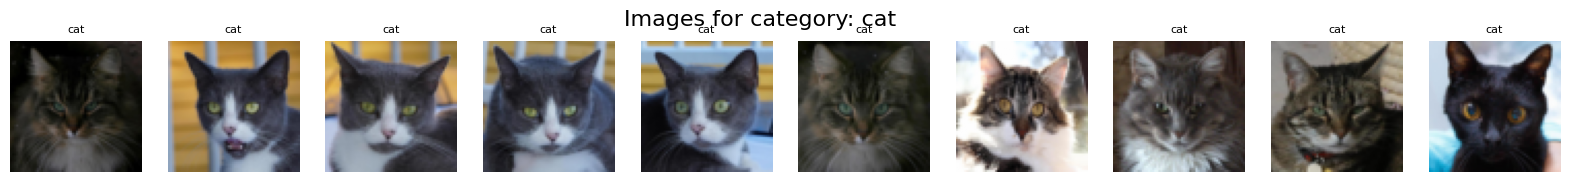

In [37]:
# Visualize images from a specific category
visualize_images(train_dataset, category_label="cat", num_images=10)


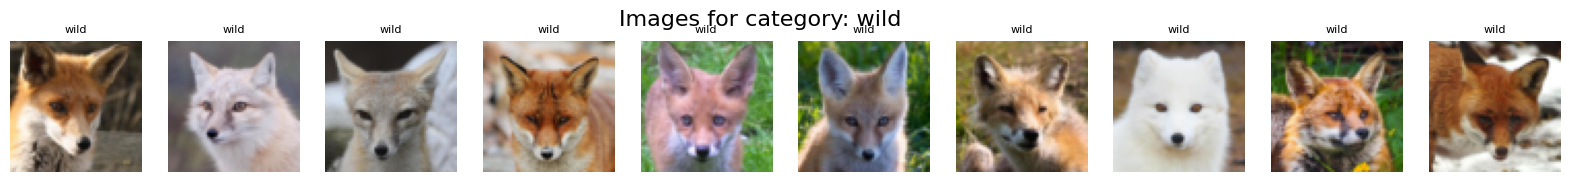

In [38]:
visualize_images(train_dataset, category_label="wild", num_images=10)


In [39]:
def vae_loss_function(recon_x, x, mu, log_var):
    """
    VAE loss: Reconstruction loss + KL divergence
    """
    recon_loss = F.mse_loss(recon_x, x, reduction="sum")  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return recon_loss + kl_divergence


def train_vae(model, train_loader, optimizer, device):
    """
    Train the VAE for one epoch.
    """
    model.train()
    running_loss = 0.0

    for inputs in train_loader:  # Labels are not needed for VAE
        inputs = inputs.to(device)
        optimizer.zero_grad()

        recon_x, mu, log_var = model(inputs)
        loss = vae_loss_function(recon_x, inputs, mu, log_var)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader.dataset)
    return avg_loss


def evaluate_vae(model, eval_loader, device):
    """
    Evaluate the VAE after each epoch.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs in eval_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss = vae_loss_function(recon_x, inputs, mu, log_var)
            running_loss += loss.item()

    avg_loss = running_loss / len(eval_loader.dataset)
    return avg_loss


def run_vae_training(
    model, train_loader, eval_loader, device, num_epochs, learning_rate=0.001, project="vae_training", name="vae_run"
):
    """
    Train and evaluate the VAE with W&B logging.
    """
    wandb.init(project=project, name=name, config={"learning_rate": learning_rate, "num_epochs": num_epochs})
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    eval_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = train_vae(model, train_loader, optimizer, device)
        eval_loss = evaluate_vae(model, eval_loader, device)

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Log metrics to W&B
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "eval_loss": eval_loss})

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}")

    wandb.finish()
    return model, train_losses, eval_losses

In [40]:
# Encoder Network
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)  # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)  # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)  # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(256 * 4 * 4, latent_dim)
        
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.batch_norm1(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv4(x)))
        
        x = x.view(x.size(0), -1)
        
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.conv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)    # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)     # 32x32 -> 64x64
        
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(x.size(0), 256, 4, 4)
        
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.relu(self.batch_norm3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))
        
        return x

# VAE class combining Encoder and Decoder
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [41]:
latent_dim = 128
model = ConvVAE(latent_dim=latent_dim).to(device)

In [42]:
model

ConvVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
    (fc_var): Linear(in_features=4096, out_features=128, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=128, out_features=4096, bias=True)
    (conv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), paddi

In [43]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=100, learning_rate=0.001
)

  1%|▌                                                      | 1/100 [00:09<14:56,  9.05s/it]

Epoch 1/100
Train Loss: 2517.4617
Eval Loss: 1143.6879


  2%|█                                                      | 2/100 [00:18<14:54,  9.13s/it]

Epoch 2/100
Train Loss: 1035.4558
Eval Loss: 942.0018


  3%|█▋                                                     | 3/100 [00:27<14:50,  9.18s/it]

Epoch 3/100
Train Loss: 909.2341
Eval Loss: 861.9496


  4%|██▏                                                    | 4/100 [00:36<14:28,  9.05s/it]

Epoch 4/100
Train Loss: 839.3996
Eval Loss: 815.5575


  5%|██▊                                                    | 5/100 [00:45<14:27,  9.13s/it]

Epoch 5/100
Train Loss: 796.3811
Eval Loss: 781.8863


  6%|███▎                                                   | 6/100 [00:54<14:21,  9.16s/it]

Epoch 6/100
Train Loss: 765.0708
Eval Loss: 745.3143


  7%|███▊                                                   | 7/100 [01:03<14:02,  9.06s/it]

Epoch 7/100
Train Loss: 738.7563
Eval Loss: 730.0039


  8%|████▍                                                  | 8/100 [01:12<13:50,  9.03s/it]

Epoch 8/100
Train Loss: 720.1742
Eval Loss: 727.9826


  9%|████▉                                                  | 9/100 [01:21<13:38,  8.99s/it]

Epoch 9/100
Train Loss: 707.5090
Eval Loss: 701.2751


 10%|█████▍                                                | 10/100 [01:30<13:37,  9.08s/it]

Epoch 10/100
Train Loss: 691.3197
Eval Loss: 697.3820


 11%|█████▉                                                | 11/100 [01:40<13:35,  9.16s/it]

Epoch 11/100
Train Loss: 678.0470
Eval Loss: 681.1640


 12%|██████▍                                               | 12/100 [01:49<13:19,  9.09s/it]

Epoch 12/100
Train Loss: 668.9533
Eval Loss: 671.1498


 13%|███████                                               | 13/100 [01:58<13:06,  9.04s/it]

Epoch 13/100
Train Loss: 663.3395
Eval Loss: 662.6460


 14%|███████▌                                              | 14/100 [02:06<12:55,  9.02s/it]

Epoch 14/100
Train Loss: 652.1221
Eval Loss: 653.7303


 15%|████████                                              | 15/100 [02:16<12:49,  9.05s/it]

Epoch 15/100
Train Loss: 644.1320
Eval Loss: 646.6090


 16%|████████▋                                             | 16/100 [02:25<12:43,  9.09s/it]

Epoch 16/100
Train Loss: 639.4468
Eval Loss: 650.5961


 17%|█████████▏                                            | 17/100 [02:34<12:30,  9.04s/it]

Epoch 17/100
Train Loss: 634.2868
Eval Loss: 644.2107


 18%|█████████▋                                            | 18/100 [02:43<12:18,  9.01s/it]

Epoch 18/100
Train Loss: 629.6699
Eval Loss: 643.7744


 19%|██████████▎                                           | 19/100 [02:52<12:16,  9.09s/it]

Epoch 19/100
Train Loss: 628.4261
Eval Loss: 641.3282


 20%|██████████▊                                           | 20/100 [03:01<12:01,  9.02s/it]

Epoch 20/100
Train Loss: 624.8515
Eval Loss: 656.8659


 21%|███████████▎                                          | 21/100 [03:10<11:49,  8.98s/it]

Epoch 21/100
Train Loss: 618.8109
Eval Loss: 633.0491


 22%|███████████▉                                          | 22/100 [03:19<11:38,  8.96s/it]

Epoch 22/100
Train Loss: 614.7607
Eval Loss: 627.5229


 23%|████████████▍                                         | 23/100 [03:28<11:29,  8.96s/it]

Epoch 23/100
Train Loss: 612.3612
Eval Loss: 630.7005


 24%|████████████▉                                         | 24/100 [03:37<11:28,  9.06s/it]

Epoch 24/100
Train Loss: 609.3492
Eval Loss: 636.3566


 25%|█████████████▌                                        | 25/100 [03:46<11:22,  9.10s/it]

Epoch 25/100
Train Loss: 609.0030
Eval Loss: 621.7068


 26%|██████████████                                        | 26/100 [03:55<11:08,  9.04s/it]

Epoch 26/100
Train Loss: 602.2412
Eval Loss: 621.1543


 27%|██████████████▌                                       | 27/100 [04:04<11:05,  9.12s/it]

Epoch 27/100
Train Loss: 599.9873
Eval Loss: 629.5774


 28%|███████████████                                       | 28/100 [04:14<11:00,  9.18s/it]

Epoch 28/100
Train Loss: 598.6837
Eval Loss: 612.6441


 29%|███████████████▋                                      | 29/100 [04:23<10:56,  9.24s/it]

Epoch 29/100
Train Loss: 597.4059
Eval Loss: 626.9851


 30%|████████████████▏                                     | 30/100 [04:32<10:47,  9.25s/it]

Epoch 30/100
Train Loss: 596.8329
Eval Loss: 615.1333


 31%|████████████████▋                                     | 31/100 [04:42<10:39,  9.26s/it]

Epoch 31/100
Train Loss: 591.3572
Eval Loss: 613.6009


 32%|█████████████████▎                                    | 32/100 [04:51<10:30,  9.27s/it]

Epoch 32/100
Train Loss: 593.4215
Eval Loss: 614.4044


 33%|█████████████████▊                                    | 33/100 [05:00<10:22,  9.29s/it]

Epoch 33/100
Train Loss: 590.6651
Eval Loss: 617.9864


 34%|██████████████████▎                                   | 34/100 [05:09<10:13,  9.29s/it]

Epoch 34/100
Train Loss: 587.9732
Eval Loss: 615.6245


 35%|██████████████████▉                                   | 35/100 [05:18<09:55,  9.16s/it]

Epoch 35/100
Train Loss: 586.1769
Eval Loss: 618.5644


 36%|███████████████████▍                                  | 36/100 [05:27<09:45,  9.14s/it]

Epoch 36/100
Train Loss: 581.8580
Eval Loss: 613.2500


 37%|███████████████████▉                                  | 37/100 [05:36<09:29,  9.04s/it]

Epoch 37/100
Train Loss: 581.6006
Eval Loss: 615.8498


 38%|████████████████████▌                                 | 38/100 [05:45<09:23,  9.09s/it]

Epoch 38/100
Train Loss: 578.1513
Eval Loss: 620.6682


 39%|█████████████████████                                 | 39/100 [05:54<09:10,  9.03s/it]

Epoch 39/100
Train Loss: 578.5366
Eval Loss: 612.0687


 40%|█████████████████████▌                                | 40/100 [06:03<08:59,  8.99s/it]

Epoch 40/100
Train Loss: 574.9647
Eval Loss: 609.2332


 41%|██████████████████████▏                               | 41/100 [06:12<08:56,  9.09s/it]

Epoch 41/100
Train Loss: 570.7373
Eval Loss: 599.3668


 42%|██████████████████████▋                               | 42/100 [06:21<08:44,  9.04s/it]

Epoch 42/100
Train Loss: 571.8531
Eval Loss: 605.4167


 43%|███████████████████████▏                              | 43/100 [06:31<08:39,  9.11s/it]

Epoch 43/100
Train Loss: 572.4908
Eval Loss: 605.7028


 44%|███████████████████████▊                              | 44/100 [06:40<08:33,  9.18s/it]

Epoch 44/100
Train Loss: 568.1958
Eval Loss: 602.2203


 45%|████████████████████████▎                             | 45/100 [06:53<09:24, 10.26s/it]

Epoch 45/100
Train Loss: 568.9429
Eval Loss: 598.4753


 46%|████████████████████████▊                             | 46/100 [07:06<10:08, 11.27s/it]

Epoch 46/100
Train Loss: 570.1988
Eval Loss: 592.5948


 47%|█████████████████████████▍                            | 47/100 [07:20<10:39, 12.06s/it]

Epoch 47/100
Train Loss: 565.7898
Eval Loss: 602.2826


 48%|█████████████████████████▉                            | 48/100 [07:34<10:49, 12.49s/it]

Epoch 48/100
Train Loss: 568.0995
Eval Loss: 601.6717


 49%|██████████████████████████▍                           | 49/100 [07:48<11:01, 12.96s/it]

Epoch 49/100
Train Loss: 562.6222
Eval Loss: 597.4434


 50%|███████████████████████████                           | 50/100 [08:02<11:07, 13.36s/it]

Epoch 50/100
Train Loss: 559.7851
Eval Loss: 599.4535


 51%|███████████████████████████▌                          | 51/100 [08:15<10:50, 13.28s/it]

Epoch 51/100
Train Loss: 560.6094
Eval Loss: 596.4101


 52%|████████████████████████████                          | 52/100 [08:29<10:39, 13.33s/it]

Epoch 52/100
Train Loss: 559.2555
Eval Loss: 589.7733


 53%|████████████████████████████▌                         | 53/100 [08:42<10:26, 13.34s/it]

Epoch 53/100
Train Loss: 554.1391
Eval Loss: 594.6597


 54%|█████████████████████████████▏                        | 54/100 [08:53<09:38, 12.58s/it]

Epoch 54/100
Train Loss: 556.5434
Eval Loss: 600.0431


 55%|█████████████████████████████▋                        | 55/100 [09:02<08:36, 11.47s/it]

Epoch 55/100
Train Loss: 554.3484
Eval Loss: 593.1638


 56%|██████████████████████████████▏                       | 56/100 [09:11<07:55, 10.81s/it]

Epoch 56/100
Train Loss: 553.5022
Eval Loss: 593.1939


 57%|██████████████████████████████▊                       | 57/100 [09:20<07:26, 10.39s/it]

Epoch 57/100
Train Loss: 550.3645
Eval Loss: 596.3684


 58%|███████████████████████████████▎                      | 58/100 [09:30<07:01, 10.04s/it]

Epoch 58/100
Train Loss: 550.2715
Eval Loss: 593.5947


 59%|███████████████████████████████▊                      | 59/100 [09:39<06:38,  9.72s/it]

Epoch 59/100
Train Loss: 550.2266
Eval Loss: 598.4570


 60%|████████████████████████████████▍                     | 60/100 [09:48<06:24,  9.60s/it]

Epoch 60/100
Train Loss: 547.7670
Eval Loss: 589.7119


 61%|████████████████████████████████▉                     | 61/100 [09:57<06:10,  9.49s/it]

Epoch 61/100
Train Loss: 547.7029
Eval Loss: 591.5138


 62%|█████████████████████████████████▍                    | 62/100 [10:07<05:58,  9.43s/it]

Epoch 62/100
Train Loss: 546.6231
Eval Loss: 591.2097


 63%|██████████████████████████████████                    | 63/100 [10:16<05:46,  9.38s/it]

Epoch 63/100
Train Loss: 543.0103
Eval Loss: 590.8054


 64%|██████████████████████████████████▌                   | 64/100 [10:25<05:32,  9.23s/it]

Epoch 64/100
Train Loss: 543.8970
Eval Loss: 586.0476


 65%|███████████████████████████████████                   | 65/100 [10:34<05:24,  9.26s/it]

Epoch 65/100
Train Loss: 540.7824
Eval Loss: 586.3470


 66%|███████████████████████████████████▋                  | 66/100 [10:43<05:13,  9.22s/it]

Epoch 66/100
Train Loss: 540.7349
Eval Loss: 586.9075


 67%|████████████████████████████████████▏                 | 67/100 [10:52<05:03,  9.21s/it]

Epoch 67/100
Train Loss: 537.1685
Eval Loss: 587.8258


 68%|████████████████████████████████████▋                 | 68/100 [11:01<04:51,  9.10s/it]

Epoch 68/100
Train Loss: 539.1323
Eval Loss: 602.5622


 69%|█████████████████████████████████████▎                | 69/100 [11:11<04:45,  9.22s/it]

Epoch 69/100
Train Loss: 537.4900
Eval Loss: 596.9561


 70%|█████████████████████████████████████▊                | 70/100 [11:20<04:33,  9.12s/it]

Epoch 70/100
Train Loss: 537.3178
Eval Loss: 589.1106


 71%|██████████████████████████████████████▎               | 71/100 [11:29<04:25,  9.15s/it]

Epoch 71/100
Train Loss: 535.8351
Eval Loss: 586.9269


 72%|██████████████████████████████████████▉               | 72/100 [11:38<04:14,  9.09s/it]

Epoch 72/100
Train Loss: 535.4724
Eval Loss: 585.4719


 73%|███████████████████████████████████████▍              | 73/100 [11:47<04:04,  9.06s/it]

Epoch 73/100
Train Loss: 530.9076
Eval Loss: 589.3740


 74%|███████████████████████████████████████▉              | 74/100 [11:56<03:53,  8.98s/it]

Epoch 74/100
Train Loss: 530.1133
Eval Loss: 585.7398


 75%|████████████████████████████████████████▌             | 75/100 [12:04<03:43,  8.95s/it]

Epoch 75/100
Train Loss: 532.3247
Eval Loss: 587.9979


 76%|█████████████████████████████████████████             | 76/100 [12:14<03:37,  9.05s/it]

Epoch 76/100
Train Loss: 530.0674
Eval Loss: 587.7349


 77%|█████████████████████████████████████████▌            | 77/100 [12:23<03:29,  9.12s/it]

Epoch 77/100
Train Loss: 528.9172
Eval Loss: 586.9393


 78%|██████████████████████████████████████████            | 78/100 [12:32<03:21,  9.14s/it]

Epoch 78/100
Train Loss: 527.8106
Eval Loss: 582.4342


 79%|██████████████████████████████████████████▋           | 79/100 [12:41<03:13,  9.19s/it]

Epoch 79/100
Train Loss: 528.6031
Eval Loss: 583.1511


 80%|███████████████████████████████████████████▏          | 80/100 [12:51<03:03,  9.19s/it]

Epoch 80/100
Train Loss: 527.7432
Eval Loss: 582.5772


 81%|███████████████████████████████████████████▋          | 81/100 [13:00<02:54,  9.18s/it]

Epoch 81/100
Train Loss: 527.7550
Eval Loss: 585.5693


 82%|████████████████████████████████████████████▎         | 82/100 [13:09<02:45,  9.21s/it]

Epoch 82/100
Train Loss: 524.3716
Eval Loss: 582.9099


 83%|████████████████████████████████████████████▊         | 83/100 [13:18<02:37,  9.24s/it]

Epoch 83/100
Train Loss: 524.7232
Eval Loss: 583.0350


 84%|█████████████████████████████████████████████▎        | 84/100 [13:28<02:28,  9.26s/it]

Epoch 84/100
Train Loss: 523.5956
Eval Loss: 583.1248


 85%|█████████████████████████████████████████████▉        | 85/100 [13:37<02:19,  9.28s/it]

Epoch 85/100
Train Loss: 523.6928
Eval Loss: 583.3966


 86%|██████████████████████████████████████████████▍       | 86/100 [13:46<02:09,  9.27s/it]

Epoch 86/100
Train Loss: 522.7635
Eval Loss: 584.4557


 87%|██████████████████████████████████████████████▉       | 87/100 [13:56<02:00,  9.29s/it]

Epoch 87/100
Train Loss: 522.6741
Eval Loss: 584.7146


 88%|███████████████████████████████████████████████▌      | 88/100 [14:06<01:55,  9.62s/it]

Epoch 88/100
Train Loss: 521.0747
Eval Loss: 582.5735


 89%|████████████████████████████████████████████████      | 89/100 [14:20<02:00, 10.99s/it]

Epoch 89/100
Train Loss: 520.3805
Eval Loss: 583.5860


 90%|████████████████████████████████████████████████▌     | 90/100 [14:34<01:59, 11.98s/it]

Epoch 90/100
Train Loss: 521.0439
Eval Loss: 583.8441


 91%|█████████████████████████████████████████████████▏    | 91/100 [14:49<01:53, 12.61s/it]

Epoch 91/100
Train Loss: 520.6042
Eval Loss: 583.5439


 92%|█████████████████████████████████████████████████▋    | 92/100 [15:02<01:43, 12.96s/it]

Epoch 92/100
Train Loss: 518.9521
Eval Loss: 582.3210


 93%|██████████████████████████████████████████████████▏   | 93/100 [15:16<01:32, 13.25s/it]

Epoch 93/100
Train Loss: 520.5042
Eval Loss: 582.0832


 94%|██████████████████████████████████████████████████▊   | 94/100 [15:31<01:21, 13.61s/it]

Epoch 94/100
Train Loss: 518.4023
Eval Loss: 582.2482


 95%|███████████████████████████████████████████████████▎  | 95/100 [15:44<01:08, 13.64s/it]

Epoch 95/100
Train Loss: 516.3385
Eval Loss: 582.5944


 96%|███████████████████████████████████████████████████▊  | 96/100 [15:58<00:54, 13.73s/it]

Epoch 96/100
Train Loss: 515.7446
Eval Loss: 585.9940


 97%|████████████████████████████████████████████████████▍ | 97/100 [16:09<00:38, 12.78s/it]

Epoch 97/100
Train Loss: 517.3494
Eval Loss: 585.7088


 98%|████████████████████████████████████████████████████▉ | 98/100 [16:18<00:23, 11.69s/it]

Epoch 98/100
Train Loss: 515.9073
Eval Loss: 587.0581


 99%|█████████████████████████████████████████████████████▍| 99/100 [16:27<00:10, 10.93s/it]

Epoch 99/100
Train Loss: 516.0665
Eval Loss: 585.2632


100%|█████████████████████████████████████████████████████| 100/100 [16:36<00:00,  9.97s/it]

Epoch 100/100
Train Loss: 514.8586
Eval Loss: 582.9822


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
eval_loss,█▆▅▅▄▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch,100
eval_loss,582.98222
train_loss,514.85859


In [52]:
def visualize_reconstructions(model, dataset, device, num_images=8):
    """
    Visualizes original and reconstructed images from the VAE.
    
    Args:
        model: Trained VAE model.
        dataset: Dataset to sample images from.
        device: Device (CPU or CUDA) to perform inference.
        num_images: Number of images to visualize.
    """
        
    model.eval()
    
    # Randomly sample images from the dataset
    indices = torch.randint(0, len(dataset), size=(num_images,))
    images = torch.stack([dataset[idx] for idx in indices]).to(device)

    with torch.no_grad():
        recon_images, _, _ = model(images)  # Pass images through the VAE

    # Convert tensors to CPU for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))
    
    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Original")
        
        # Reconstructed images
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Reconstructed")
    
    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8631468..0.93107325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9574571..0.9039842].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87516826..0.9352975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.6

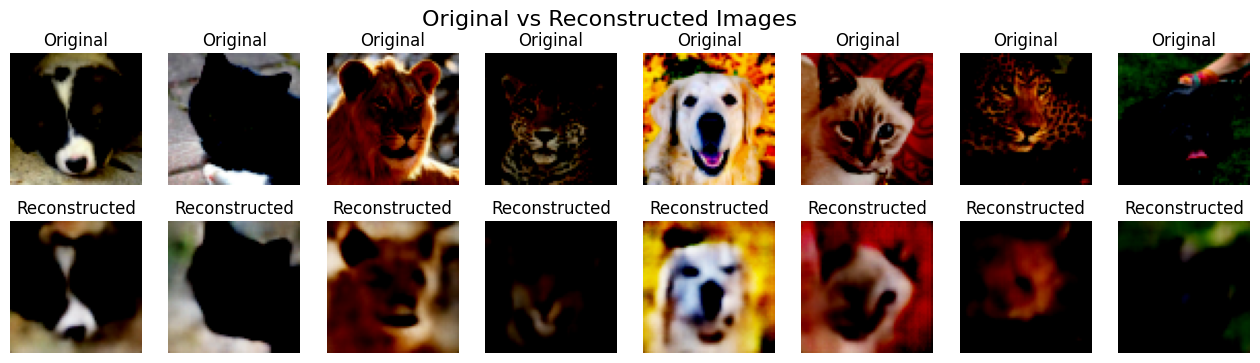

In [53]:
# Visualize reconstructions
visualize_reconstructions(model, val_dataset, device)

In [63]:
def visualize_reconstructions(model, dataloader, device, mean, std, num_images=8):
    """
    Visualizes original and reconstructed images from the VAE.
    
    Args:
        model: Trained VAE model.
        dataloader: DataLoader to sample images from.
        device: Device (CPU or CUDA) to perform inference.
        mean: Mean used for normalization during dataset preprocessing.
        std: Standard deviation used for normalization during dataset preprocessing.
        num_images: Number of images to visualize.
    """
    model.eval()

    # Move mean and std to the same device as images
    mean = mean.to(device)
    std = std.to(device)

    # Randomly sample a batch of images from the dataloader
    data_iter = iter(dataloader)
    images = next(data_iter)  # Assuming the dataloader returns images and labels
    images = images.to(device)

    # If you need only `num_images` samples
    images = images[:num_images]

    with torch.no_grad():
        recon_images, _, _ = model(images)  # Pass images through the VAE

    # Denormalize the images
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    recon_images = recon_images * std[None, :, None, None] + mean[None, :, None, None]

    # Convert tensors to CPU for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Original")

        # Reconstructed images
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Reconstructed")

    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

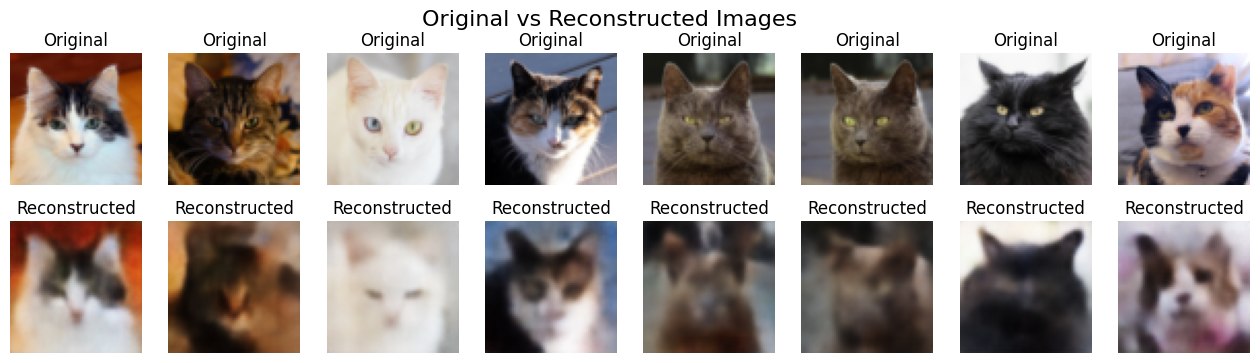

In [64]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)